In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [2]:
vi = 0.01

Vol = vi*10**(-14); NA = 6.02*10**(23); Cal = NA*Vol*10**(-6)

TC = 0.158

kc1 = 0.15*Cal*TC
# production of p53 [molecules/min]

kc2 = 0.1*TC
# degradation of p53 by mdm2 [1/min]

kc3 = 0.1*Cal
# degradation of p53 by mdm2 [molecules]

kc4 = 0.1/Cal*TC
# production of mdm2 - mRNA [1/(molecules*min)]

kc5 = 0.1*TC 
# degradation of mdm2 - mRNA [1/min]

kc6 = 0.2*TC 
# production of mdm2 [1/min]

kc7 = 0.1*TC 
# degradation of mdm2 [1/min]

kc8 = 0.0036 
# binding of mdm2 and nutlin [1/(molecules*min)]

In [3]:
def p_change(t, p, m, Mf, Mb, n):
    dpdt = kc1 - kc2*Mf*(p / (kc3 + p))
    return dpdt

def m_change(t, p, m, Mf, Mb, n):
    dmdt = (kc4 * p**2 - kc5 * m)
    return dmdt

def M_free_change(t, p, m, Mf, Mb, n):
    dM_freedt = kc6 * m - kc7 * Mf - kc8*n*Mf
    return dM_freedt

def M_bound_change(t, p, m, Mf, Mb, n):
    dM_bounddt = - kc7*Mb + kc8*n*Mf
    return dM_bounddt

def n_change(t, p, m, Mf, Mb, n):
    dndt = -kc8*n*Mf
    return dndt

def samlet_system(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = p_change(t, *y)
    dydt[1] = m_change(t, *y)
    dydt[2] = M_free_change(t, *y)
    dydt[3] = M_bound_change(t, *y)
    dydt[4] = n_change(t, *y)
    return dydt

In [4]:
t_samlet = (0, 5000)

p0, m0, Mf0, Mb0, n0 = 100, 1, 1, 1, 1

y0 = [p0, m0, Mf0, Mb0, n0]

In [5]:
samlet_løsning = solve_ivp(samlet_system, t_samlet, y0, method='RK45')
print(samlet_løsning)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.698e-02 ...  4.989e+03  5.000e+03]
        y: [[ 1.000e+02  1.001e+02 ...  6.308e+01  6.877e+01]
            [ 1.000e+00  1.253e+00 ...  3.343e+01  3.945e+01]
            ...
            [ 1.000e+00  9.988e-01 ... -7.076e-07 -1.458e-07]
            [ 1.000e+00  9.997e-01 ...  6.556e-07  1.346e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4148
     njev: 0
      nlu: 0


In [6]:
t_int, p_int, m_int, Mf_int, Mb_int, n_int = samlet_løsning["t"], samlet_løsning["y"][0], samlet_løsning["y"][1], samlet_løsning["y"][2], samlet_løsning["y"][3], samlet_løsning["y"][4]

In [7]:
plt.plot(t, p, color="green", label="[p53]")
plt.plot(t, m, color="orange", label="[mdm2 - mRNA]")
plt.plot(t, Mf, color="red", label="mdm2 Free")


plt.legend()
plt.plot()

NameError: name 't' is not defined

Hvorfor eksploderer mængden af `Mb`?

In [8]:
plt.plot(t,Mb)

NameError: name 't' is not defined

### Peakfinding med scipy

"For several conditions the interval borders can be specified with arrays matching x in shape which enables dynamic constrains based on the sample position."

In [10]:
def find_map(t, y): #mean, amplitude, period
    y_peaks = find_peaks(y)[0]
    y_troughs = find_peaks(-y)[0]

    # Only keep peaks after the 10 first peaks. We assume that the period and amplitude will be approx. stable after this.
    stable_peaks = None
    stable_troughs = None
    if len(y_peaks) > 12 and len(y_peaks) > len(y_troughs):
        stable_peaks = y_peaks[10:-2]
        stable_troughs = y_troughs[10:-1]
    else:
        stable_peaks = y_peaks[10:-1]
        stable_troughs = y_troughs[10:-1]
        
    # Is it true that N is larger when using troughs also? So that the uncertainty is smaller?
    period = np.mean((np.diff(t[stable_peaks]) + np.diff(t[stable_troughs]))/2)
    # TODO: Calculate uncertainty for this!
    
    amplitude = np.mean((y[stable_peaks] - y[stable_troughs])/2)

    mean_value = np.mean(np.concatenate((y[stable_peaks] - amplitude, y[stable_troughs] + amplitude)))

    return period, amplitude, mean_value, stable_peaks, stable_troughs

In [12]:
period, amplitude, mean_value, stable_peaks, stable_troughs = find_map(t_int, p_int)

In [13]:
print(period, amplitude, mean_value)

329.1125843870209 32.35464308364189 52.49419813103056


In [225]:
def sim_onoff_nutlin(perioder, T_int, omega, p0, m0, Mf0, Mb0, A_ext):

    T_ext = omega * T_int 

    history = {"t":[] ,"p": [], "m": [], "Mf": [], "Mb":[], "n":[]}

    # TODO: Undersøg max_step i fremtiden
    for i in range(perioder):
        if i == 0:
            state = p0, m0, Mf0, Mb0, 0
            sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5)
            t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t)
            history["p"].extend(p)
            history["m"].extend(m)
            history["Mf"].extend(Mf)
            history["Mb"].extend(Mb)
            history["n"].extend(n)
        
        # Nutlin turned off for one period
        elif i % 2 == 0:
            state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], 0
            sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5)
            t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t + history["t"][-1])
            history["p"].extend(p)
            history["m"].extend(m)
            history["Mf"].extend(Mf)
            history["Mb"].extend(Mb)
            history["n"].extend(n)

        # Nutlin turned on for one period
        else:
            state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], A_ext
            sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5)
            t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t + history["t"][-1])
            history["p"].extend(p)
            history["m"].extend(m)
            history["Mf"].extend(Mf)
            history["Mb"].extend(Mb)
            history["n"].extend(n)
    
    return history

In [226]:
p_int[-1]

68.7677614186749

In [350]:
desired_omega = 1/2

In [351]:
nutlin_sim1 = sim_onoff_nutlin(20000, period, desired_omega, p_int[-1], m_int[-1], Mf_int[-1], Mb_int[-1], amplitude/2)

In [352]:
t_1, p_1, m_1, Mb_1, Mf_1, n_1 = nutlin_sim1["t"], nutlin_sim1["p"], nutlin_sim1["m"], nutlin_sim1["Mb"], nutlin_sim1["Mf"], nutlin_sim1["n"]

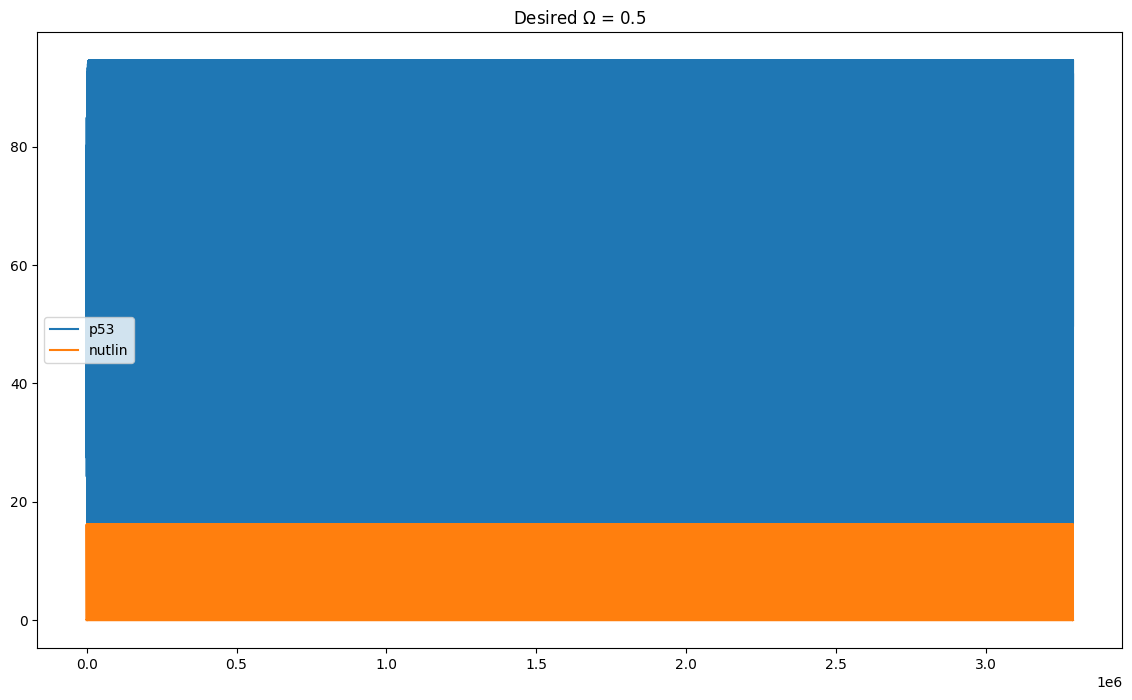

In [353]:
plt.figure(figsize=(14, 8))

plt.plot(t_1, p_1, label="p53")
plt.plot(t_1, n_1, label="nutlin")
# plt.plot(t_1, m_1, label="mRNA")
# plt.plot(t_1, Mb_1, label="Mb")
# plt.plot(t_1, Mf_1, label="Mf")

plt.title(rf"Desired $\Omega$ = {desired_omega}")

plt.legend()

# plt.title(f"Oscillationer af p53 koncentration med perioden T = {period:.4} [min]")

In [359]:
peaks_nutlin = np.array(find_peaks(n_1)[0])
troughs_p53 = np.array(find_peaks(-1*np.array(p_1), height=-mean_value)[0])

In [360]:
print(peaks_nutlin)
print(troughs_p53)

[    36    118    197 ... 729852 729925 729998]
[    54    130    203 ... 729831 729904 729977]


In [369]:
mean_value

52.49419813103056

In [361]:
t_1[9]

37.88983048809912

[]

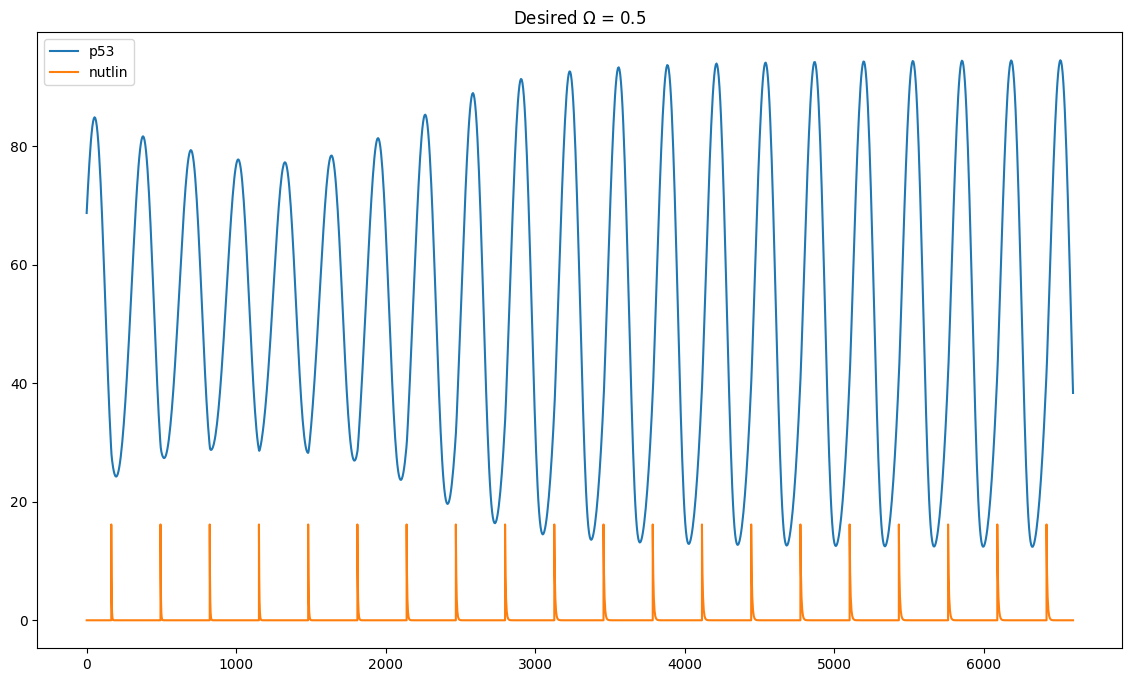

In [389]:
plt.figure(figsize=(14, 8))

plt.plot(t_1[:1500], p_1[:1500], label="p53")
plt.plot(t_1[:1500], n_1[:1500], label="nutlin")

# for i in range(len(peaks_nutlin)):
#     plt.scatter(t_1[peaks_nutlin[i]], n_1[peaks_nutlin[i]], c="red", marker='*')

# for i in range(len(troughs_p53)):
#     plt.scatter(t_1[troughs_p53[i]], p_1[troughs_p53[i]], c="black", marker='*')

plt.title(rf"Desired $\Omega$ = {desired_omega}")
plt.legend()
plt.plot()

In [376]:
def calculate_entrainment(t, peaks, troughs):
    nutlin_step = 1/desired_omega

    distances = []
    if len(troughs) < len(peaks):
        for i in range(len(troughs)):
            if i * nutlin_step < len(peaks):
                index_nutlin = int(i*nutlin_step)
                index_p = i * 2
                distances.append(abs(t[troughs[index_p]] - t[peaks[index_nutlin]]))
    elif len(troughs) >= len(peaks):
        for i in range(len(peaks)):
            if i * nutlin_step < len(troughs):
                index_nutlin = int(i*nutlin_step)
                index_p = i * 2
                distances.append(abs(t[troughs[index_p]] - t[peaks[index_nutlin]]))
    
    return distances

In [380]:
distance = calculate_entrainment(t_1, peaks_nutlin, troughs_p53)

In [381]:
print(distance)

[33.67716119678653, 8.578496321573766, 0.0, 36.66598588980514, 66.72747012159107, 81.80379609909187, 86.8424467510522, 91.86300914129151, 91.87459487891647, 91.88120021363011, 96.88497858219489, 96.88714379564863, 96.88838602190935, 96.8890992271572, 96.8895088815334, 96.88974424142361, 96.88987948372778, 96.88995720332059, 96.89000186862722, 96.89002753844215, 96.89004229151215, 96.89005077054208, 96.89005564372201, 96.89005844450912, 96.89006005422198, 96.89006097938181, 96.89006151110516, 96.8900618167063, 96.89006199234791, 96.89006209329455, 96.89006215131303, 96.89006218465875, 96.89006220382362, 96.89006221483942, 96.8900622211695, 96.89006222480748, 96.89006222689932, 96.89006222809985, 96.89006222879107, 96.8900622291876, 96.8900622294168, 96.89006222954777, 96.89006222962416, 96.89006222966782, 96.89006222968965, 96.8900622297042, 96.89006222971511, 96.89006222971875, 96.89006222972239, 96.89006222972239, 96.89006222972966, 96.89006222972966, 96.89006222972966, 96.89006222972

In [382]:
x_dummy = np.arange(len(distance))

Text(0.5, 1.0, 'Entrainment? Nook jo')

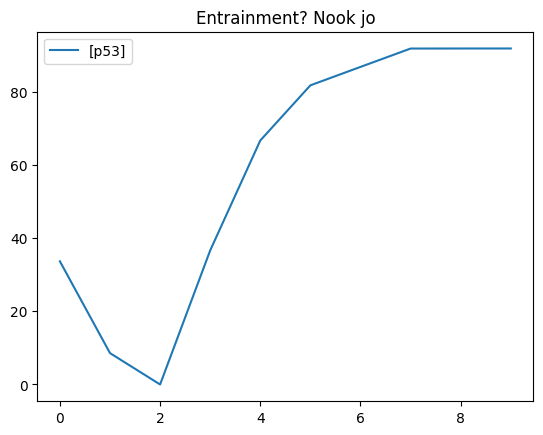

In [390]:
plt.plot(x_dummy[:10], distance[:10], label="[p53]")

plt.legend()

plt.title(f"Entrainment? Nook jo")